In [2]:
# Note that the following code has been written with the help of sentdex tutorials on pytorch, however, the code
# has been written by me, since I was trying to understand as to how CNNs work. 

import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = True

In [5]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label,f)
                        img = cv2.imread(path, 0)
                        img = cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                        if label == self.CATS:
                            self.catcount+= 1
                        elif label == self.DOGS:
                            self.dogcount+= 1
                    except Exception as e:
                        pass
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print("Cats: ",self.catcount)
        print("Dogs: ",self.dogcount)
        

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
    

100%|██████████| 12501/12501 [02:43<00:00, 76.52it/s]


Cats:  12476
Dogs:  12470


In [6]:
training_data = np.load("training_data.npy", allow_pickle = True)
print(len(training_data))

24946


In [8]:
import torch

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

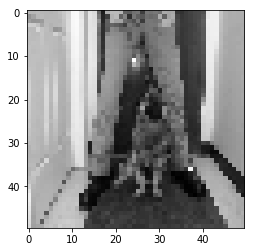

tensor([0., 1.])


In [11]:
import matplotlib.pyplot as plt

plt.imshow(X[0], cmap = "gray")
plt.show()
print(y[0])

In [13]:
# Now that we have pre-processed the data, let's build the Convolutional Neural Network

import torch
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # init run for parent class
        self.conv1 = nn.Conv2d(1,32,5) # Input is 1 image, output is 32 features, kernel size is 5
        self.conv2 = nn.Conv2d(32,64,5) # Input 32 features, output 64 features, kernel size 5
        self.conv3 = nn.Conv2d(64,128,5)
        
        # Now, in order to find the shape of the flattened output, we shall pass a radom tensor to see
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear,512) # flattening
        self.fc2 = nn.Linear(512,2) # finally, goes to a simple 2 class classification (dog vs cat)
    
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

In [21]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [22]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

VAL_PCT = 0.1 # 10% data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [23]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X),len(test_X))

22452 2494


In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [30]:
def fwd_pass(X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

In [32]:
def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

0.47 tensor(0.2739, grad_fn=<MseLossBackward>)


In [33]:
# Now let us move on to the main training part
    
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)
def train(net):
    BATCH_SIZE = 100
    EPOCHS = 10

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")
train(net)

  0%|          | 0/225 [00:00<?, ?it/s]

model-1585665425


100%|██████████| 225/225 [01:23<00:00,  2.96it/s]


In [34]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:03<00:00, 800.42it/s]

Accuracy:  0.735


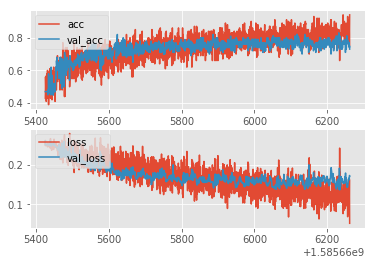

In [35]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = "model-1585665425" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

In [36]:
# It will converge properly with more epochs, but I ran it on a CPU, so, ran fewer epochs. With a GPU,
# you can run more epochs, which will imply a greater accuracy.